In [70]:
using FFTW
using LinearAlgebra
using Plots

In [74]:
cmd = `jupyter-nbconvert presentation.ipynb --to slides --TagRemovePreprocessor.remove_input_tags=\{\"remove_input\"\} --post serve --ServePostProcessor.port=9997 --ServePostProcessor.ip=\"0.0.0.0\"`
run(cmd);

Serving your slides at http://0.0.0.0:9997/presentation.slides.html
Use Control-C to stop this server

Interrupted


To render slides, interrupt the above cell (esc + I), then rerun it.

Slides are rendered to

http://72.179.3.141:9997/presentation.slides.html

For pdf version:

http://72.179.3.141:9997/presentation.slides.html?print-pdf

<center><h1>GPU Filter Banks for Audio</h1></center>

<center><h2>Dan Jacobellis<br>Utsha Khondkar</h2></center>

![](img/fft_matrix.svg)

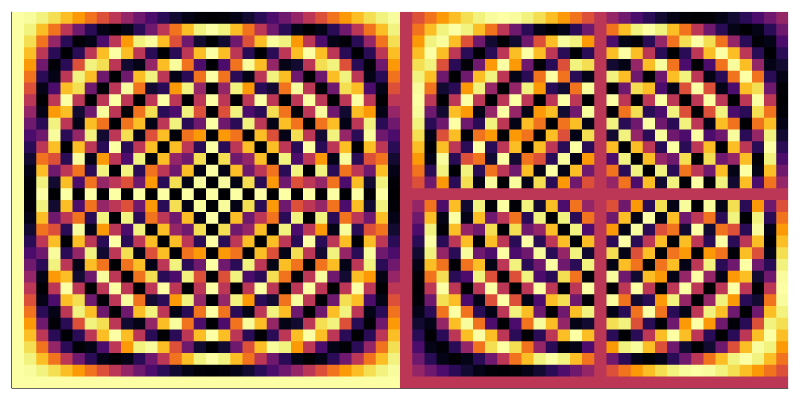

In [ ]:
X = fft(Matrix(1.0I,32,32), 1);
heatmap([real(X) imag(X)], axis=nothing, colorbar=nothing,size=(800,400))

* Introduce team

Our project is on adapting filter banks which are used in audio applications to the GPU.

You might not be familiar with the terminology "filter bank". But, you've probably seen a filter bank before, it just might have been called something else.

For example, the fast fourier transform, the FFT, can be considered a a type of filter bank. In fact this picture right here is actually showing the filter coefficients that you could use to perform a discrete fourier transform. 

So why do we care about filter banks?

<center><h1>Time-Frequency Analysis</h1></center>

<video width="800" height="400" controls src="img/chirp.mp4" />

Filter banks are the primary tool of time-frequency analysis, and time-frequency analysis is the primary tool of audio signal processing.

In practice, most audio signals are difficult to deal with in the time domain.

Sometimes, we can get away with just taking a Fourier transform to put it into the frequency domain.

Usually, the most useful representation is somewhere in between.

As an example, let's listen to this bird chirp

Now, let's look at it in the time domain, the frequency domain, and as a joint time-frequency representation.

<center><h1>Time-Frequency Analysis</h1></center>

![](img/chirp.svg)

If we were to just look at it in the time domain, we might have some idea about when these chirps occur or how loud they are.

If we were were to just look at it in the frequency domain, we would have some idea of what frequencies are present, but not necessarily when they occur or how they change.

The joint representation is where most of the interesting problems are solved.

For example, it's easy to see, for the chirp, where the signal is and where the noise is.

In the time or frequency domains, the signal is everywhere. In the time-frequency domain, the signal occupies a relatively small area.

Our auditory systems exploit this. The anatomy of our inner ears are actually performing a type of time-frequency analysis.

The current approaches to machine learning for audio start by constructing some sort of time-frequency representation like this.

The question is: what is the best way to construct these things, and how do we do it efficiently in parallel?

<center><h1>Filter Banks</h1></center>

![](img/helmholtz.png)

The basic tool to construct a time-frequency distribution is the filter bank.

We just take a bunch of filters which each respond to a narrow range of frequencies, and run the signal through each of the filters in parallel.

This idea has been around for a long time.

This is one of the first analog filter banks which used these things called helmholtz resonators which behave as a bandpass filter. This was created by Hemlholtz who was one of the pioneers in audio signal processing, even if we didn't call it 'signal processing' back then.

Now, we use digital filters, which are applied using discrete convolution.

As you probably know, GPUs are really good at doing convolution.

But for whatever reason, most people only ever use one type of filterbank because it's easy and there's lots of accessible software to do it. That's the FFT.

<center><h1>FFT as a filter bank</h1></center>
<img width="500" src="img/uniform_tile.png" />

The image I showed earlier was made using an FFT. Even though the FFT takes a signal from the time domain and puts it into the frequency domain, we can use it to make a joint representation.

All we have to do is take short windows of the signal and apply the FFT to each window. When you do that, you're basically tiling the time-frequency plane like this

The problem with this representation is that the frequency bands are uniformly spaced. For a lot of tasks, we really want a constant-Q spacing

<center><h1>Constant-Q</h1></center>

$$ Q = \frac{\text{center frequency}}{\text{bandwidth}} $$

<img width="500" src="img/cq_tiling.png"/> 

A Constant Q representation divides the frequency axis so that each frequency band has the same Q factor.

The Q factor is just the ratio of the center frequency to bandwidth.

In this example, The Q factor is chosen so that each of these frequency bands is an octave.

For signals like speech or music which are for human consumption, this type of representation is preferred because it matches our perception. We have better ability to discriminate small differences of frequency when the frequencies are low. But at the same time, we have a better ability to track changes over time when the frequencies are high.

<center><h1>Wavelets</h1></center>

<img width="800" src="img/trends1.svg"/> 

These types of transforms can be achieved using something called a discrete wavelet transform, which is really just a type of filterbank.

However, deep learning has displaced most of the study of wavelets, and people stopped writing software and algorithms for them.

Even though they've been around for a long time, doing discrete wavelet transforms on the GPU is a pretty arcane task. 

<center><h1>Mel Filter Banks</h1></center>

<img width="800" src="img/trends2.svg"/> 

Since audio signal processing is a very interdisciplinary field, and people don't have time to become an expert on discrete wavelet transforms and filter banks, most people end up using something called a mel filterbank to do these constant q transforms.

<center><h1>What's wrong with FFTs and Mel Filters?</h1></center>

Missing:

* Parameterization/tunability
* Perfect reconstruction
* Meaningful/interpretable phase representation
* Generalization to multiple channels/phased arrays
* Efficient implementation for oversampled representations.

We've implemented an efficient algorithm on the GPU that can address some of these problems. I'll hand it off to Utsha to go through the algorithm.

<center><h1>Haar Decomposition</h1></center>

In [ ]:
x = round.(Int,10*randn(8));

In [ ]:
print(x)

[7, 1, -13, 20, 4, 7, -18, 5]

In [ ]:
s = conv(x,[1, 1])[2:2:end];
d = conv(x,[1,-1])[2:2:end];

In [ ]:
println("s = ",s); print("d = ",d)

s = [8, 7, 11, -13]
d = [-6, 33, 3, 23]

In [ ]:
y1 = (s-d)/2;
y2 = (s+d)/2;

In [ ]:
println(Int.(y1)); print(Int.(y2))

[7, -13, 4, -18]
[1, 20, 7, 5]

Our algorithm is very similar to the discrete wavelet transform, so we will go through a simple example to demonstrate what that is.

This example shows what is likely the simplest type of perfect reconstruction filter bank.

For simplicity, we've taken the input samples to be integers it works with any type of signal.

We apply two filters using convolution. One filter is low-pass and the other is high pass.

You can see that the sum and difference not only decompose the signal into high and low frequency components, but they do so without increasing the number of words required to represent the signal.

This is an example of “critically sampled” dyadic filterbank. Critically sampled means that the size of data after applying the filter bank is exactly same as original data, and no information is lost. "Dyadic" just refers to the fact that there are two filters in the filter bank.

We call the first part an analysis filterbank, since it is decomposing a 1-d signal into multiple frequency bands.

We call the reverse operation a synthesis filterbank since it reconstructs the 1-d signal from the frequency bands.

In this example, we end up with two signals that have half the time resolution. But, we went from having only one frequeny band to two, so we have doubled our frequency resolution.

<center><h1>Convolution</h1></center>

(almost) embarrassingly parallel

Dot product requires $\log_2(M)$ time steps

$ y = x \ast h = 
\begin{bmatrix}
    x_1 & 0 & \cdots & 0 & 0 \\
    x_2 & x_1 &      & \vdots & \vdots \\
    x_3 & x_2 & \cdots & 0 & 0 \\
    \vdots & x_3 & \cdots & x_1 & 0 \\
    x_{n-1} & \vdots & \ddots & x_2 & x_1 \\
    x_n & x_{n-1} &      & \vdots & x_2 \\
    0 & x_n & \ddots & x_{n-2} & \vdots \\
    0 & 0 & \cdots & x_{n-1} & x_{n-2} \\
    \vdots & \vdots &        & x_n & x_{n-1} \\
    0 & 0 & 0 & \cdots & x_n
\end{bmatrix}
$
$\begin{bmatrix}
    0 \\
    0 \\
    \vdots\\
    h_1 \\
    h_2 \\
    \vdots \\
    h_m \\
    0 \\
    \vdots \\
    0 \\
\end{bmatrix}$



All of these operations can be described in terms of convolution, upsampling, and downsampling.

Often, people think about using FFTs to perform "fast" convolution. However, that is only true assuming that the filter is similar in size to the signal, which is not true in our case.

Either way, the algorithm is almost embarrassingly parallel.

The only sequential component is that we have to add up a list of numbers in order to calculate a dot product, but this part can be completed in log M time steps

<center><h1>Tree structure</h1></center>

![](img/dyadic_analysis_filterbank.svg)

The Haar decomposition shown eariler was just one filter bank. But why should we stop there?

We can recursively apply this procedure to the outputs of each filter to increase the frequency resolution. Since each step in the decomposition can be inverted, so can the entire process.

We apply the highpass, then downsample, the lowpass, then downsample, then recurse.

The output $y$ is the time-frequency distribution which has useful properties for many signal analysis problems, such as compression, denoising, or machine learning.

<center><h1>Time-frequency Tiling</h1></center>

<img width="400" src="img/uniform_tile.png"/><img width="331" src="img/cq_tiling.png" />

If we recursively apply this procedure, we refine the time-frequency tiling of our representation.

Depending on how we structure the tree, we can either get a uniform tiling (similar to STFT), or a constant-Q tiling.

The structure on the left has a simple convenient data structure: we can represent each tile as the element of a matrix.

The structure on the right is often a better representation of the underlying signal structure, and provides good time resolution at the places we need and good frequency resolution in the places we need.

What if we could have the best of both worlds?

That's exactly what we did!

<center><h1>Hybrid Octave + Uniform</h1></center>

Input:
```
1-element Vector{NTuple{4, Int64}}:
 (524288, 1, 1, 1)

```

Output of analysis filter banks:
```
11-element Vector{NTuple{4, Int64}}:
 (8192, 32, 1, 1)
 (4096, 32, 1, 1)
 (2048, 32, 1, 1)
 (1024, 32, 1, 1)
 (512, 32, 1, 1)
 (256, 32, 1, 1)
 (128, 32, 1, 1)
 (64, 32, 1, 1)
 (32, 32, 1, 1)
 (16, 32, 1, 1)
 (16, 32, 1, 1)
```

Takes $O \left( \log_2(N) \right)$ recursive applications of the filter bank

Each application requires a convolution which is $O \left( \log_2(M) \right)$ (assuming $p=NM$)

In our algorithm, we recursively apply analysis filters to decompose the low frequency band until we have 10 octaves of resolution (plus a DC band)

Then for each octave, we recursively apply the analysis filters but now we decompose both the low-frequency and high-frequency components.

Exploit highly optimized filtering operations in CUDA to make each convolution $O(log M)$

We also implemented the corresponding synthesis filterbank.

<center><h1>Memory Considerations</h1></center>

* Speech: few seconds long, fs = 16000, N ~ 10^5 per record.
* Music: minutes long, two channels, fs = 48000, N ~ 10^7 per record.
* Passive sonar array: 100s of channels, fs in the kHz, ~ 10^10 per hour.

Ideally, $p=NM$

Not realistic. Often limited by ability of CPU/data storage to feed data to GPU.

Make $p$ a large as possible while keeping a constant stream of data.

<center><h1>Results</h1></center>

![](img/timing1.svg)

<center><h1>Speedup</h1></center>

(compared to Mel Filter Banks using Librosa + numpy)

![](img/speedup.svg)

# Demo

https://danjacobellis.github.io/GPUfilterbank/